In [4]:
import EntropyHub as eh
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import mutual_info_classif
warnings.filterwarnings('ignore')

In [5]:
def generate_entropy(dataset_heart_participant):

    xx = np.array(dataset_heart_participant.iloc[:,1:])
    # Approximate entropy
    approximate_entropy, _ = eh.ApEn(xx)
    # Sample entropy, note
    sample_entrpy, _, _ = eh.SampEn(xx)
    # Fuzzy entropy, note
    fuzzy_entropy, _, _ = eh.FuzzEn(xx)
    # Permutation entropy,note
    permutation_entropy, _, _ = eh.PermEn(xx)
    # Spectral band Entropy (we don't know the edge frequencies)
    spectral_entropy = eh.SpecEn(xx) 
    # Dispersion Entropy, note
    dispersion_entropy,_ = eh.DispEn(xx)
    # Increment entropy
    increment_entropy = eh.IncrEn(xx)
    # Phase entropy, note
    phase_entropy = eh.PhasEn(xx)
    # Slope entropy
    slope_entropy = eh.SlopEn(xx)
    
    # generate entropy dataset
    entropy_feature_participant = [approximate_entropy[-1],sample_entrpy[-1],
                               fuzzy_entropy[-1], permutation_entropy[-1], spectral_entropy[-1],
                               dispersion_entropy, increment_entropy, phase_entropy, slope_entropy[-1]]
    entropy_feature_participant = pd.DataFrame(entropy_feature_participant).T
    entropy_feature_participant.columns = ['approximate_entropy','sample_entrpy','fuzzy_entropy','permutation_entropy',
                                        'spectral_entropy','dispersion_entropy','increment_entropy','phase_entropy',
                                        'slope_entropy']
    return entropy_feature_participant
    
    

1. Pre-process raw data.

In [6]:
df = pd.read_csv('Epileptic Seizure Recognition.csv')
df.head().T
df = df.drop('Unnamed', 1)
y_df = df['y']
y_df.head().T
y_df.value_counts()
y_binary = pd.Series(np.where(df['y'].values == 1, 1, 0), df['y'].index)
y_binary.head().T
y_binary.value_counts()
x_df = df.drop('y', 1)

under_sampler = RandomUnderSampler(random_state=1)
X_res, y_res = under_sampler.fit_resample(x_df, y_binary)
X_res = X_res.reset_index()
y_res = y_res.reset_index()

2. Generate entropy features.

In [7]:
dataset_heart_entropy = X_res.groupby('index').apply(generate_entropy).reset_index()
dataset_entropy = pd.merge(dataset_heart_entropy, y_res, on='index')
dataset_entropy = dataset_entropy.iloc[:,2:]
dataset_entropy.columns = ['approximate_entropy','sample_entrpy','fuzzy_entropy','permutation_entropy',
                                        'spectral_entropy','dispersion_entropy','increment_entropy','phase_entropy',
                                        'slope_entropy', 'label']
dataset_entropy.head()

,approximate_entropy,sample_entrpy,fuzzy_entropy,permutation_entropy,spectral_entropy,dispersion_entropy,increment_entropy,phase_entropy,slope_entropy,label
0,0.708682,0.951721,3.757755,0.997212,0.657458,1.715557,3.958137,0.770781,1.431248,0
1,0.515262,0.430783,3.527379,0.999424,0.491408,1.310835,4.511815,0.870861,1.730537,0
2,0.236955,0.151141,3.087152,0.985561,0.494851,1.306461,3.231968,0.677415,1.419816,0
3,0.608533,0.818099,4.151910,0.999793,0.610794,1.621223,3.562775,0.814031,1.312034,0
4,0.668724,0.900927,3.405699,0.999424,0.594791,1.632200,3.807975,0.772775,1.369924,0


3. Feature selection.

In [8]:
# determine the mutual information
X_train = dataset_entropy.iloc[:,:-1]
y_train = dataset_entropy.iloc[:, -1]
mutual_info = mutual_info_classif(X_train, y_train)
mutual_info

array([0.3082738 , 0.26932693, 0.11585279, 0.10196743, 0.04158635,
       0.07046382, 0.36284361, 0.17627706, 0.30790367])

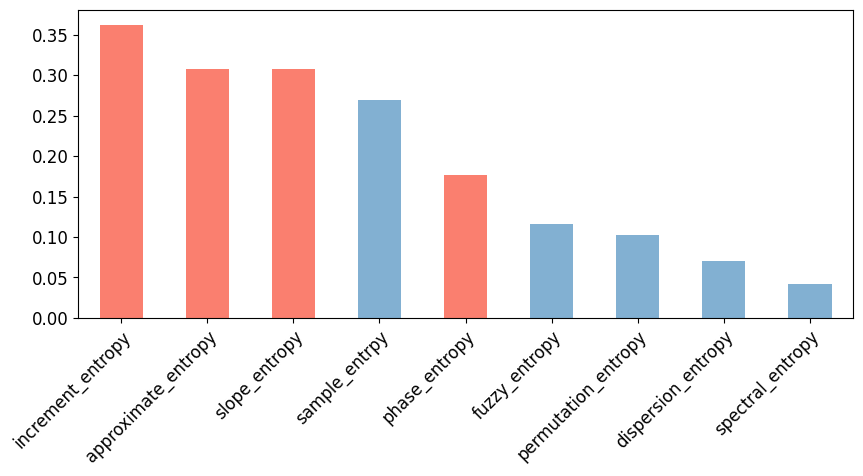

In [9]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
mutual_info.sort_values(ascending=False).plot.bar(figsize=(10, 4),color = ['#FA7F6F','#FA7F6F','#FA7F6F','#82B0D2','#FA7F6F','#82B0D2','#82B0D2','#82B0D2','#82B0D2'])
plt.xticks(rotation=45,fontsize=12,rotation_mode='anchor',ha="right")
plt.yticks(rotation=0,fontsize=12)
plt.savefig('EntropySelection2.png', bbox_inches="tight", dpi=700)

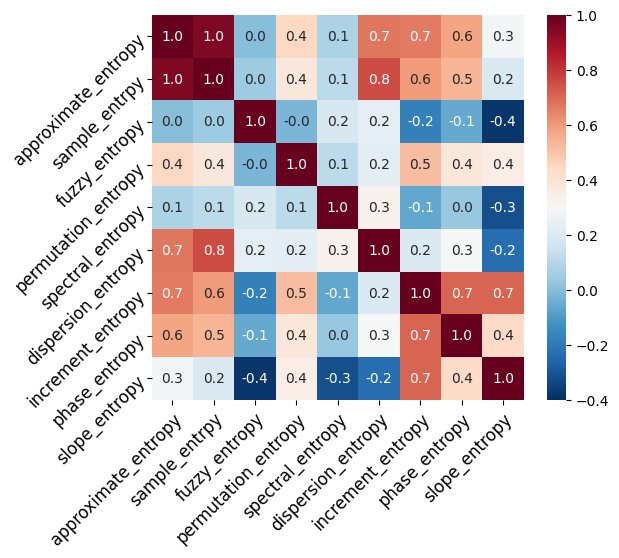

In [10]:
cor = X_train.corr()
plt.figure(figsize=(6,5))
g = sns.heatmap(cor, cmap="RdBu_r",annot=True, vmin=-0.4, vmax=1, fmt='.1f')
g.set_xticklabels(g.get_xticklabels(), rotation = 45, fontsize = 12, rotation_mode='anchor',ha="right")
g.set_yticklabels(g.get_xticklabels(), rotation = 45, fontsize = 12, rotation_mode='anchor',ha="right")
# plt.yticks(rotation=0)
# plt.xticks(rotation=0)
plt.savefig('EntropySelection1.png', bbox_inches="tight", dpi=700)

4. Save entropy features.

In [11]:
dataset_entropy = pd.DataFrame(dataset_entropy, columns=['approximate_entropy','phase_entropy','increment_entropy','slope_entropy','label'])
dataset_entropy.to_csv('dataset_all_entropy.csv')
dataset_entropy

,approximate_entropy,phase_entropy,increment_entropy,slope_entropy,label
0,0.708682,0.770781,3.958137,1.431248,0
1,0.515262,0.870861,4.511815,1.730537,0
2,0.236955,0.677415,3.231968,1.419816,0
3,0.608533,0.814031,3.562775,1.312034,0
4,0.668724,0.772775,3.807975,1.369924,0
...,...,...,...,...,...
4595,0.481232,0.815294,2.879954,1.264968,1
4596,0.429597,0.636864,3.180031,1.192092,1
4597,0.458316,0.682672,3.178631,1.147188,1
4598,0.454452,0.834913,3.026419,1.225162,1
